In [1]:
using Pkg

In [2]:
Pkg.activate(dirname(pwd()))

  Activating environment at `~/Documents/GitHub/ComputationalHeatTransfer.jl/Project.toml`


In [3]:
using ComputationalHeatTransfer
using LaTeXStrings
using DifferentialEquations
using JLD2
using Plots
gr()  


┌ Info: Precompiling ComputationalHeatTransfer [5fc296c8-2eb5-40dc-a46d-98a68011a900]
└ @ Base loading.jl:1342


Plots.GRBackend()

## Control Console

In [4]:
fluid_type = "butane"
# fluid_type = "R134a"
Tᵥ = 291.2

ΔTthres = 1.0
δfilm = 2e-5
plate_d = 2e-3;
hc1 = 3000.0
# hc1 = 0.0
hc2 = 3000.0
Eratio = 0.35

0.35

In [5]:
# fluid_type = "butane"
# Tᵥ = 291.2

# ΔTthres = 0.1
# δfilm = 1e-5
# plate_d = 2e-3;
# # hc1 = 3000.0
# hc1 = 0.0
# hc2 = 3000.0
# Eratio = 0.3

# Properies

### Earth property

In [6]:
gravity = 9.8

9.8

### Solid Physical parameters

In [7]:
ρₛ = 2730; # density
cₛ  = 8.93e02; # specific heat
kₛ  = 1.93e02; # heat conductivity
# plate_d
params = HeatConductionParameters(ρₛ ,cₛ ,kₛ ,thickness=plate_d)

HeatConductionParameters(2730.0, 893.0, 193.0, 7.916682048820907e-5, 0.002)

### Fluid Physical parameters

In [8]:
# fluid_type = "butane"
# Tᵥ = 291.2

In [9]:
using UnPack

p_fluid = get_saturation_property(fluid_type,Tᵥ)
@unpack Cpₗ,ρₗ,μₗ,hₗ,kₗ,Prₗ,Cpᵥ,ρᵥ,μᵥ,hᵥ,kᵥ,Prᵥ,σ,P,R,M,Rkg,αₗ,νₗ,νᵥ,hₗᵥ = p_fluid;

# Plate Conduction

### Geometry parameters

In [10]:
Lx = 0.1524; # plate size x
Ly = 0.0648; # plate size y

In [11]:
xlim = (-Lx/2,Lx/2) .*1.0
ylim = (-Ly/2,Ly/2) .*1.0
Δx, Δt = setstepsizes(params.α,gridPe=8.0,fourier=0.3)


(0.0006333345639056725, 0.001520002953373614)

### Set up the evaporator and condenser

In [12]:
inch = 2.54e-2;

## big heater

In [99]:
power = 10 #watts
total_heater_area = 2.0inch*2.0inch;

In [100]:
qe = power/total_heater_area
# hc = 1500.0*1.5
# hc = 4000.0
Tc = Tᵥ

291.2

In [101]:
eb1 = Rectangle(0.5inch,1.0inch,1.5*Δx)
Tfe = RigidTransform((0.7inch,-0.0),0.0)
Tfe(eb1)

eb2 = Rectangle(0.5inch,1.0inch,1.5*Δx)
Tfe = RigidTransform((-0.7inch,-0.0),0.0)
Tfe(eb2)

cb1 = Rectangle(0.5inch*0.9,Ly*0.9/2,1.5*Δx)
Tfc = RigidTransform((-2.5inch,-0.0),0.0)
Tfc(cb1)

cb2 = Rectangle(0.5inch*0.9,Ly*0.9/2,1.5*Δx)
Tfc = RigidTransform((2.5inch,-0.0),0.0)
Tfc(cb2)

eparams1 = PrescribedHeatFluxRegion(qe,eb1);
eparams2 = PrescribedHeatFluxRegion(qe,eb2);
cparams1 = PrescribedHeatModelRegion(hc1,Tc,cb1);
cparams2 = PrescribedHeatModelRegion(hc2,Tc,cb2);

# small heater

In [102]:
# power = 20 #watts
# total_heater_area = 0.5inch*0.5inch;

In [103]:
# qe = power/total_heater_area
# # hc = 1500.0*1.5
# # hc = 4000.0
# Tc = Tᵥ

In [104]:
# eb1 = Rectangle(0.25inch,0.25inch,1.5*Δx)
# Tfe = RigidTransform((0.0inch,-0.0),0.0)
# Tfe(eb1)

# eb2 = Rectangle(0.5inch,1.0inch,1.5*Δx)
# Tfe = RigidTransform((-0.7inch,-0.0),0.0)
# Tfe(eb2)

# cb1 = Rectangle(0.5inch*0.9,Ly*0.9/2,1.5*Δx)
# Tfc = RigidTransform((-2.5inch,-0.0),0.0)
# Tfc(cb1)

# cb2 = Rectangle(0.5inch*0.9,Ly*0.9/2,1.5*Δx)
# Tfc = RigidTransform((2.5inch,-0.0),0.0)
# Tfc(cb2)

# eparams1 = PrescribedHeatFluxRegion(qe,eb1);
# eparams2 = PrescribedHeatFluxRegion(0*qe,eb2);
# cparams1 = PrescribedHeatModelRegion(hc1,Tc,cb1);
# cparams2 = PrescribedHeatModelRegion(hc2,Tc,cb2);

### Set up the OHP

In [105]:
ds = 1.5Δx
nturn = 16
width_ohp = 46.25*1e-3
length_ohp = 133.83*1e-3
gap = 1e-3
pitch = width_ohp/(2*nturn+1)
x0, y0 = length_ohp/2 * 1.02, width_ohp/2

x, y, xf, yf = ComputationalHeatTransfer.construct_ohp_curve(nturn,pitch,length_ohp,gap,ds,x0,y0,false,false,3pi/2)
# one_loop_gap = 1e-2
# x, y, xf, yf = construct_oneloop_curve(0,0,ds,length_ohp,one_loop_gap,pi/2)


ohp = BasicBody(x,y)

Basic pointwise-specified body with 4877 points
   Current position: (0.0,0.0)
   Current angle (rad): 0.0


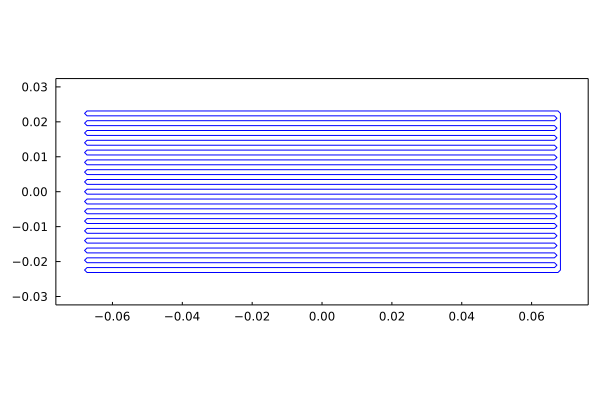

In [106]:
plot(ohp,fillalpha=0,linecolor=:blue,xlims=xlim,ylims=ylim,framestyle = :box)

In [107]:
ohpgeom = ComputationalHeatTransfer.LineSourceParams(ohp)

LineSourceParams{BasicBody{4877, RigidBodyTools.ClosedBody}}(Basic pointwise-specified body with 4877 points
   Current position: (0.0,0.0)
   Current angle (rad): 0.0
)

### Create the system

In [108]:
sys = HeatConduction(params,Δx,xlim,ylim,Δt,qline=ohpgeom,qflux=[eparams1,eparams2],qmodel=[cparams1,cparams2])

Unbounded Heat conduction system on a grid of size 250 x 108 and 0 static immersed points


In [109]:
qtmp = zeros(numpts(ohp));

In [110]:
u0 = newstate(sys)
tspan = (0.0,0.1)
integrator = init(u0,tspan,sys);
Tn = temperature(integrator) .+ Tᵥ;

In [111]:
fill!(qtmp,-0.0)
set_linesource_strength!(sys,qtmp)

Unbounded Heat conduction system on a grid of size 250 x 108 and 0 static immersed points


In [112]:
println(@__MODULE__)

Main


In [113]:
num = 100
ΔN = 100


Thist=[]

@time for i = 1:num
    Tn = ADI_timemarching!(Tn,sys,Δt)
    
    if mod(i,ΔN) == 0
        push!(Thist,deepcopy(Tn))
    end
end

  0.408406 seconds (40.71 k allocations: 1.054 GiB, 13.42% gc time)


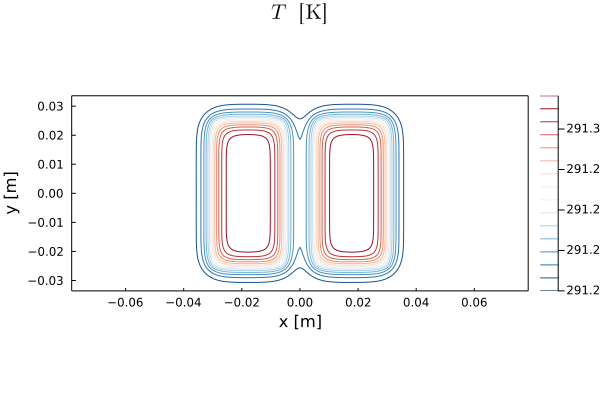

In [114]:
plot(Tn,sys.grid,legend=true,color=cgrad(:RdBu,rev=true),xlabel="x [m]",ylabel="y [m]",title=L"T \quad [\mathrm{K}]")

# OHP inner part

### Tube geometries

In [115]:
tube_d = 1e-3; # tube diameter
peri = 4*tube_d # Tube perimeter
Ac = tube_d*tube_d # tube cross-sectional area
L2D = length_ohp # the actual length of the bended pipe in the real world
L = (sys.qline[1].arccoord[1] + sys.qline[1].arccoord[end])  # total length of the pipe when streched to a 1D pipe (an approximate here)
angle = 0*pi/2 # inclination angle 
closedornot = true

N=numpts(ohp);

In [116]:
tube = Tube(tube_d,peri,Ac,L,L2D,angle,gravity,closedornot,N);

In [117]:
typeof(tube)

Tube

### Liquid

In [118]:
Nu = 4.36
# Nu = 1.0
Hₗ = kₗ/tube_d * Nu # Nusselt number 4.36

469.1572801658905

In [119]:
X0,realratio = randomXp(tube)
# X0 = [(L/2,L/2+L2D)]

dXdt0_l = zeros(length(X0))
dXdt0_r = zeros(length(X0))
dXdt0 = map(tuple,dXdt0_l,dXdt0_r);

In [120]:
realratio

0.48979346563046045

In [121]:
# construct liquids
N=numpts(ohp)
Xarrays,θarrays = constructXarrays(X0,N,Tᵥ,L);

In [122]:
liquids=Liquid(Hₗ,ρₗ,Cpₗ,αₗ,μₗ,σ,X0,dXdt0,Xarrays,θarrays);

### Vapor

In [123]:
Hᵥ = kᵥ/tube_d * Nu # Nusselt number 4.36

69.29503570524817

In [124]:
P = 0*zeros(length(X0)) .+ TtoP(Tᵥ);
# δ = 0*zeros(length(X0)) .+ 1.0e-5;
δfilm_deposit = δfilm;
δstart = 0*zeros(length(X0)) .+ δfilm ;
δend = 0*zeros(length(X0)) .+ δfilm ;

Lvaporplug = XptoLvaporplug(X0,L,tube.closedornot)
Lfilm_start = 0.25 .* Lvaporplug
Lfilm_end = 0.25 .* Lvaporplug
# Eratio = 0.75
# δratio = 0*zeros(length(X0)) .+ 0.99;
# δ = 0*zeros(length(X0)) .+ 2.78E-02;
δmin = 2e-6
vapors=Vapor(Hᵥ,kₗ,δmin,Eratio,P,δfilm_deposit,δstart,δend,Lfilm_start,Lfilm_end);

### Wall

### nucleate boiling sites

In [125]:
# ΔTthres = 1.0; # superheat threshold

In [126]:
    nucleatenum = 256
#     Xstations = sort(rand(nucleatenum).*L);
    Xstations = LinRange(0.0,L-L/nucleatenum,nucleatenum)
#     boilingΔt = 0.05

256-element LinRange{Float64}:
 0.0,0.0181667,0.0363334,0.0545,…,4.55984,4.578,4.59617,4.61434,4.6325

In [127]:
Xwallarray,θwallarray = constructXarrays(sys.qline[1].arccoord,L,Tᵥ);
θwallarray .= Tᵥ

wall = Wall(ΔTthres,Xstations,Xwallarray,θwallarray);

In [128]:
sys0_nomapping = PHPSystem_nomapping(tube,liquids,vapors,wall);
θ_interp_walltoliquid, θ_interp_liquidtowall, H_interp_liquidtowall, P_interp_liquidtowall = sys_interpolation(sys0_nomapping)
mapping = Mapping(θ_interp_walltoliquid, θ_interp_liquidtowall, H_interp_liquidtowall, P_interp_liquidtowall);

In [129]:
L

4.650670248837519

In [130]:
sys0 = PHPSystem(tube,liquids,vapors,wall,mapping);

### construct state vector U

In [131]:
Lvaporplug = XptoLvaporplug(X0,sys0.tube.L,sys0.tube.closedornot)
M = PtoD(P) .* Lvaporplug .* Ac
# M = P.^(1/γ).* Lvaporplug



u=[XMδLtovec(X0,dXdt0,M,δstart,δend,Lfilm_start,Lfilm_end); liquidθtovec(sys0.liquid.θarrays)];
# u=[XMδtovec(X0,dXdt0,M,δ); liquidθtovec(sys0.liquid.θarrays)];

In [132]:
cb_boiling =  DiscreteCallback(boiling_condition,boiling_affect!)
# cb_boiling =  PeriodicCallback(boiling_affect!,0.01*t_to_nondi_t)
cb_vapormerging =  DiscreteCallback(merging_condition,merging_affect!)
cb_liquidmerging = DiscreteCallback(vaporMergingCondition,vaporMergingAffect!)
cb_fixdx =  DiscreteCallback(fixdx_condition,fixdx_affect!)

cbst = CallbackSet(cb_fixdx,cb_boiling,cb_vapormerging,cb_liquidmerging);
# cbst = CallbackSet(cb_vapormerging,cb_liquidmerging);

# load old data

In [133]:
# integrator_plate = load("plate_OHP_dimensional50D1.0TH1_H2250_platethickness1.5.jld2", "integrator_plate")
# sys = integrator_plate.p

In [134]:
# integrator_tube = load("tube_OHP_dimensional50D1.0TH1_H2250_platethickness1.5.jld2", "integrator_tube")

# # sysfinal = []
# # for i = 1:length(tube_hist)
# #     push!(sysfinal, deepcopy(getcurrentsys(tube_hist[i].u,tube_hist[i].p)))
# # end

In [135]:
# tube_hist = load("tube_vibration.jld2", "tube_hist")

# combine inner tube and plate together

In [137]:
tspan = (0.0, 50.0);
dt_record = tspan[2] /100;
# dt_record_tube = 0.1;

tstep = 5e-5

N_iter = 1
# tstep_plate = tstep/N_iter
# dt_record = tstep

1

In [138]:
u0 = newstate(sys)
integrator_plate = init(u0,tspan,sys)
# Tplate = temperature(integrator_plate);
temperature(integrator_plate) .= Tᵥ;

In [139]:
p = sys0
u=[XMδLtovec(X0,dXdt0,M,δstart,δend,Lfilm_start,Lfilm_end); liquidθtovec(sys0.liquid.θarrays)];
prob = ODEProblem(ODE_innertube, u, tspan, p)
integrator_tube = init(prob, RK4(),save_everystep=false, dt=tstep, callback=cbst);

## Resume

In [140]:
# integrator_plate = integrator_plate_temp;

In [141]:
# integrator_tube = tube_hist[end-4];

## Start

In [142]:
boil_hist=[]

Any[]

In [143]:
plate_T_hist = []
tube_hist  = []

currentsys = integrator_tube.p
currentsys = getcurrentsys(integrator_tube.u,currentsys);

currentsys.wall.θarray = temperature_linesource(integrator_plate)
currentsys = getcurrentsys(integrator_tube.u,currentsys)
integrator_tube.p = currentsys
qtmp = sys_to_heatflux(currentsys)
set_linesource_strength!(sys,qtmp);

integrator_plate_temp = deepcopy(integrator_plate)

t: 0.0
u: (Primal nodes in a (nx = 250, ny = 108) cell grid of type Float64 data
  Number of Primal nodes: (nx = 249, ny = 107), Float64[])

In [144]:
using Distributed
using ProgressMeter

In [145]:
tstep=4e-4

0.0004

In [146]:
integrator_plate.t

0.0

In [172]:
@showprogress for t in tspan[1]:tstep:tspan[2]
# @time for t in tspan[1]:tstep:tspan[1]    
    # reinitialize the integrator_tube to avoid some mysterious problems
    prob = ODEProblem(ODE_innertube, deepcopy(integrator_tube.u), (integrator_plate.t-tstep,integrator_plate.t), currentsys)
    integrator_tube = init(prob, RK4(), callback=cbst, dt=tstep);
    step!(integrator_tube,tstep,true);
#     integrator_tube = init(prob, RK4(), callback=cbst, tstops=tstep);
#     auto_dt_reset!(integrator_tube)
#     println(integrator_tube.dt)
#     tstops=[0.5]
#     solve!(integrator_tube);
    
    
      for j in 1:N_iter
       currentsys.wall.θarray = temperature_linesource(integrator_plate)
       currentsys = getcurrentsys(integrator_tube.u,currentsys)

       qtmp = sys_to_heatflux(currentsys)
       set_linesource_strength!(sys,qtmp)


     ADI_timemarching!(temperature(integrator_plate),sys,tstep)
    end
    integrator_plate.t += tstep
    

    if (mod(integrator_plate.t,dt_record) < 1e-6) || (mod(-integrator_plate.t,dt_record) < 1e-6)
        push!(plate_T_hist,deepcopy(temperature(integrator_plate))); 
        push!(tube_hist,deepcopy(integrator_tube));
        integrator_plate_temp = deepcopy(integrator_plate)
#         println(round(integrator_plate.t, digits=3)," total boiling number = ",length(boil_hist))
    end
    
end

Progress:   9%|███▊                                     |  ETA: 0:36:03

reconstruct dx! in3 at 53.569599999928506


Progress:  10%|████▎                                    |  ETA: 0:35:18

LoadError: InterruptException:

In [173]:
sysfinal = []
for i = 1:length(tube_hist)
    push!(sysfinal, deepcopy(getcurrentsys(tube_hist[i].u,tube_hist[i].p)))
end

In [ ]:
scatter()
for i=1:length(tube_hist)
    Lvaporplug = XptoLvaporplug(sysfinal[i].liquid.Xp,sysfinal[end-1].tube.L,sysfinal[end].tube.closedornot);
    plot!(i,Lvaporplug)
end

In [ ]:
Lvaporplug = XptoLvaporplug(sysfinal[100].liquid.Xp,sysfinal[end-1].tube.L,sysfinal[end].tube.closedornot);

In [ ]:
sum(Lvaporplug)

In [ ]:
Δθthreshold = 0.1
Δθ_array = getsuperheat.(sysfinal[end].wall.Xstations,[sysfinal[end]])
    superheat_flag = Δθ_array .> Δθthreshold
flag = zeros(length(Xstations))
    for i = 1:length(Xstations)
    flag[i] = ifamong(sysfinal[end].wall.Xstations[i], sysfinal[end].liquid.Xp, sysfinal[end].tube.L) && suitable_for_boiling(sysfinal[end],i) && superheat_flag[i]
end
plot(flag)

# plot the OHP

## Green: vapor with film-------Yellow: vapor without film-------Blue: liquid

In [ ]:
@gif for i=length(sysfinal):length(sysfinal):length(sysfinal)
    Htmp = sys_to_Harray(sysfinal[i])
    Htmp_marker = round.(div.(Htmp,Hₗ-1e-10))
    plot(ohp,clim=(0,2),fillalpha=0,linewidth=2.0,linecolor=palette([:yellow,  :blue, :green]),line_z=Htmp_marker,xlabel="x ",ylabel="y ",title=string("time = ", round(tube_hist[i].t, digits=2), "[s] \n",  "T - T0 [K]"),border=:none,axis=nothing)
end

┌ Info: Saved animation to 
│   fn = /Users/yuxuanli/Documents/GitHub/ComputationalHeatTransfer.jl/notebooks/tmp.gif
└ @ Plots /Users/yuxuanli/.julia/packages/Plots/Ra8fG/src/animation.jl:126


Plots.AnimatedGif("/Users/yuxuanli/Documents/GitHub/ComputationalHeatTransfer.jl/notebooks/tmp.gif")
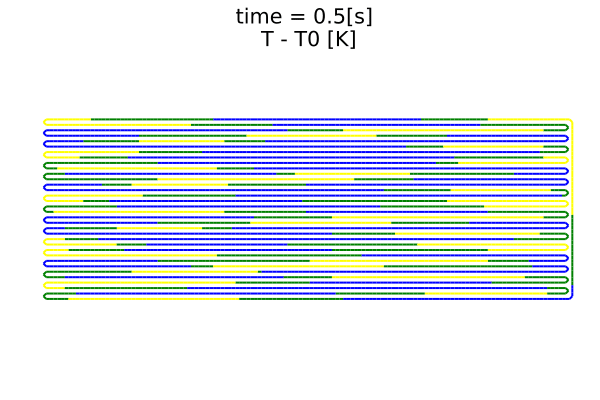

In [150]:
@gif for i=1:1:length(sysfinal)
    Htmp = sys_to_Harray(sysfinal[i])
    Htmp_marker = round.(div.(Htmp,Hₗ-1e-10))
    plot(ohp,clim=(0,2),fillalpha=0,linewidth=2.0,linecolor=palette([:yellow,  :blue, :green]),line_z=Htmp_marker,xlabel="x ",ylabel="y ",title=string("time = ", round(tube_hist[i].t, digits=2), "[s] \n",  "T - T0 [K]"),border=:none,axis=nothing)
end

In [ ]:
plot(sysfinal[end].vapor.δend,ylim=(0,6e-5))

┌ Info: Saved animation to 
│   fn = /Users/yuxuanli/Documents/GitHub/ComputationalHeatTransfer.jl/notebooks/tmp.gif
└ @ Plots /Users/yuxuanli/.julia/packages/Plots/Ra8fG/src/animation.jl:126


Plots.AnimatedGif("/Users/yuxuanli/Documents/GitHub/ComputationalHeatTransfer.jl/notebooks/tmp.gif")
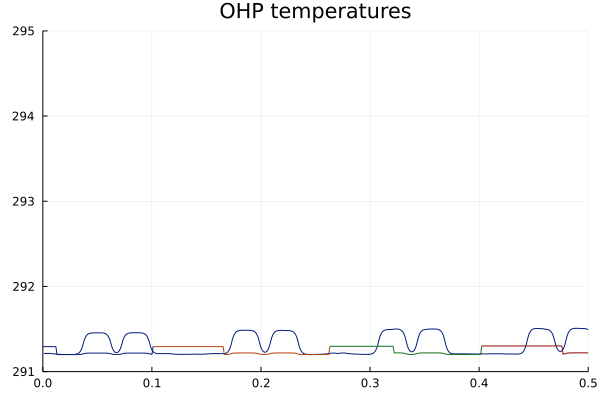

In [91]:
@gif for sysi in sysfinal
     plot(sysi,plottype="T",xlim=(0.0,0.5),ylim=(291,295))
end

In [ ]:
Tmax = maximum(plate_T_hist[20])
Tmin = minimum(plate_T_hist[1])

@gif for i = 20:20
plot(plate_T_hist[i],sys.grid,legend=true,color=cgrad(:RdBu,rev=true),clim=(Tmin,Tmax),line_z=0,xlabel="x [m]",ylabel="y [m]",title=string("time = ", round(tube_hist[i].t, digits=2), "[s] \n",  "T[K]"))
scatter!([x[1],x[4],x[8]],[y[1],y[4],y[8]])
annotate!(x[1]+0.002, y[1]+0.005, "RTD1", :color)
annotate!(x[4]+0.002, y[4]+0.005, "RTD4", :color)
annotate!(x[8]+0.002, y[8]+0.005, "RTD8", :color,legend=false)
end




In [ ]:
savefig("T_profile.svg")

┌ Info: Saved animation to 
│   fn = /Users/yuxuanli/Documents/GitHub/ComputationalHeatTransfer.jl/notebooks/tmp.gif
└ @ Plots /Users/yuxuanli/.julia/packages/Plots/Ra8fG/src/animation.jl:126


Plots.AnimatedGif("/Users/yuxuanli/Documents/GitHub/ComputationalHeatTransfer.jl/notebooks/tmp.gif")
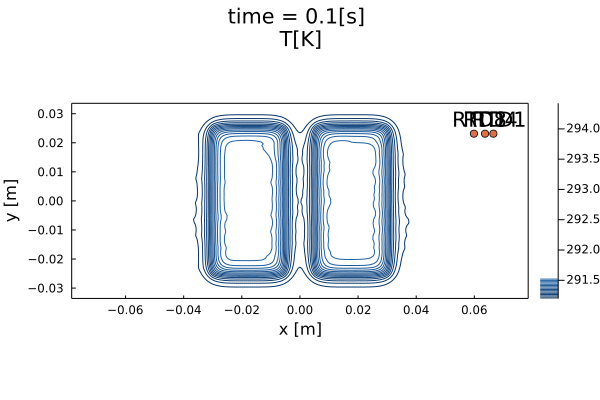

In [87]:
Tmax = maximum(plate_T_hist[end])
Tmin = minimum(plate_T_hist[1])

@gif for i = 1:1:length(plate_T_hist)
plot(plate_T_hist[i],sys.grid,legend=true,color=cgrad(:RdBu,rev=true),clim=(Tmin,Tmax),line_z=0,xlabel="x [m]",ylabel="y [m]",title=string("time = ", round(tube_hist[i].t, digits=2), "[s] \n",  "T[K]"))
scatter!([x[1],x[4],x[8]],[y[1],y[4],y[8]])
annotate!(x[1]+0.002, y[1]+0.005, "RTD1", :color)
annotate!(x[4]+0.002, y[4]+0.005, "RTD4", :color)
annotate!(x[8]+0.002, y[8]+0.005, "RTD8", :color,legend=false)
end



In [ ]:
sysfinal[end].tube.angle

## Store data

In [174]:
using JLD2

In [175]:
boil_station_hist = [elem[1] for elem in boil_hist]
boil_t_hist = [elem[2] for elem in boil_hist]
boil_data = Array(reshape([boil_station_hist;boil_t_hist], length(boil_t_hist),2));

In [176]:
save("OHP1_10W_E065_2_DT1_small.jld2","tube_hist", tube_hist, "integrator_tube",integrator_tube,"plate_T_hist", plate_T_hist, "integrator_plate", integrator_plate, "boil_data", boil_data,"ohp",ohp)

In [ ]:
boil_data

In [ ]:
scatter(boil_data[:,2],boil_data[:,1])

In [ ]:
sorted_boil_hist = boil_data[sortperm(boil_data[:, 1]), :]
num_boiling = zeros(size(Xstations))
for i = 1:size(sorted_boil_hist,1)
    num_boiling[Int64(sorted_boil_hist[i,1])] += 1
end

In [ ]:
using SparseArrays 

In [ ]:
boil_dt = 0.1

In [ ]:
tend = round(integrator_tube.t)

boil_matrix=spzeros(size(Xstations,1),Int64(round(tend/boil_dt)));
for tnum = 1:size(boil_matrix,2)
     boil_index = findall(x->Int64(round(x/boil_dt))==tnum,boil_data[:,2])
   
    if length(boil_index) != 0
        i_station_temp = Int64.(boil_data[boil_index,1])
        for i in i_station_temp
            boil_matrix[i,tnum] = 1
        end
    end
end



In [ ]:
boil_num_t = sum(boil_matrix, dims=1)'
boil_num_x = sum(boil_matrix, dims=2);

In [ ]:
plot(boil_num_t)

In [ ]:
using EasyFit

m10 = movavg(vec(boil_num_t),10)

In [ ]:
plot(m10.x)

In [ ]:
Lliquidslug = zeros(length(sysfinal))
for i = 1:length(sysfinal)
    Lliquidslug[i] = sum(XptoLliquidslug(sysfinal[i].liquid.Xp,sysfinal[i].tube.L))
end
plot(Lliquidslug)

In [ ]:
sysfinal[450].vapor.δstart

## T line graph comparision

In [178]:
filepath = "20190604_F_PD_%23001_O001_H001_P010_expA.xlsx"
xf = XLSX.readxlsx(dirname(pwd())*"/expdata/"*filepath)

Onum, Hnum, power = getconfig(filepath)
RTD,RTDt = getRTD(xf,Onum);

In [182]:
inch = 2.54e-2;

x = [-2.75inch,-1.4inch,-0.8inch,0.0,0.0,0.8inch,1.4inch,2.75inch]
y = [0.0,0.0,0.0,0.0,0.4inch,0.0,0.0,0.0];
X =  VectorData(x,y);

In [183]:
H = Regularize(X,cellsize(sys),I0=origin(sys.grid))
g = ScalarData(X);

In [184]:
ghist,thist = getgt(g,H,plate_T_hist,tube_hist);

In [185]:
sorted_boil_hist = boil_data[sortperm(boil_data[:, 1]), :]
num_boiling = zeros(size(Xstations))
for i = 1:size(sorted_boil_hist,1)
    num_boiling[Int64(sorted_boil_hist[i,1])] += 1
end

In [186]:
using SparseArrays 

In [187]:
boil_dt = 0.1

0.1

In [188]:
tend = round(integrator_tube.t)

boil_matrix=spzeros(size(Xstations,1),Int64(round(tend/boil_dt)));
for tnum = 1:size(boil_matrix,2)
     boil_index = findall(x->Int64(round(x/boil_dt))==tnum,boil_data[:,2])
   
    if length(boil_index) != 0
        i_station_temp = Int64.(boil_data[boil_index,1])
        for i in i_station_temp
            boil_matrix[i,tnum] = 1
        end
    end
end



In [189]:
boil_num_t = sum(boil_matrix, dims=1)'
boil_num_x = sum(boil_matrix, dims=2);

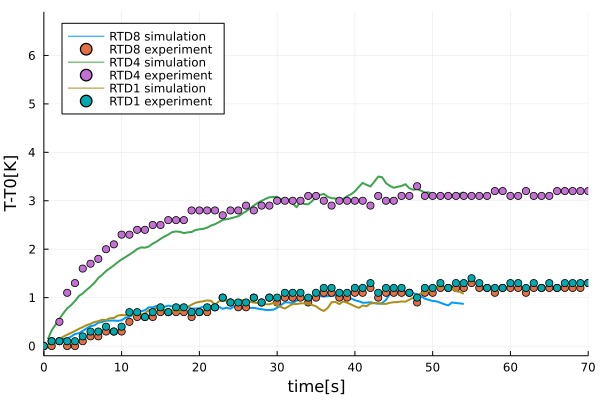

In [190]:
i = 8 #RTD number

plot(thist,ghist[i] .-Tᵥ,label=string("RTD", i," simulation"),linewidth=2)
scatter!(RTDt .- RTDt[1],RTD[:,i] .- RTD[1,i], label=string("RTD", i," experiment"),xlim=(0.0,300.0))

i = 4 #RTD number

plot!(thist,ghist[i] .-Tᵥ,label=string("RTD", i," simulation"),linewidth=2)
scatter!(RTDt .- RTDt[1],RTD[:,i] .- RTD[1,i], label=string("RTD", i," experiment"),xlim=(0.0,300.0))

i = 1 #RTD number
plot!(thist,ghist[i] .-Tᵥ,label=string("RTD", i," simulation"),linewidth=2)
scatter!(RTDt .- RTDt[1],RTD[:,i] .- RTD[1,i],legend=:topleft, label=string("RTD", i," experiment"),xlim=(0.0,70.0),xlabel="time[s]",ylabel="T-T0[K]")

In [191]:
power

10

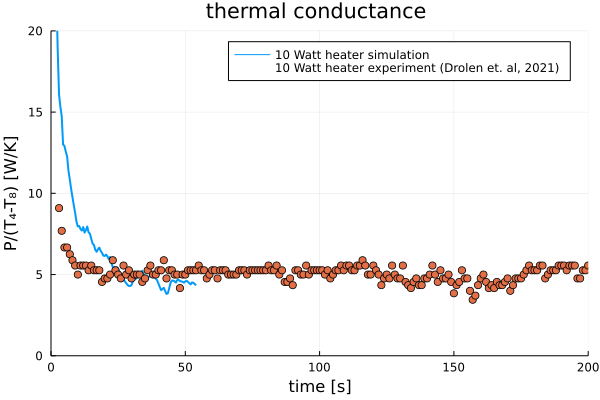

In [194]:
i1 = 4 #RTD number
i2 = 8 #RTD number

plot(thist, power ./ (ghist[i1] .-ghist[i2]),label=string("10 Watt heater simulation"),linewidth=2,ylim=(0,20))
scatter!(RTDt .- RTDt[1],power ./(RTD[:,i1] .- RTD[:,i2]), label=string("10 Watt heater experiment (Drolen et. al, 2021)"),legend=:topright,xlim=(0.0,200.0),title="thermal conductance ",xlabel="time [s]",ylabel="P/(T₄-T₈) [W/K]")

In [171]:
power ./ (ghist[i1] .-ghist[i2])

98-element Vector{Float64}:
 80.61399541663307
 34.77295592952577
 27.223240911499065
 22.418861169763797
 18.82515171436689
 16.066651353061165
 15.320687844609841
 14.731356805738002
 13.005277555843985
 12.919348537154463
 12.570651830600372
 12.27691280646151
 11.392624576008311
  ⋮
  3.8444928566245484
  4.152636538310169
  4.486153411574587
  4.63312385176988
  4.630176657836766
  4.586159149763295
  4.506483700659623
  4.664244248572099
  4.682974870398904
  4.596741804450974
  4.5802557655877205
  4.559780354012996

In [ ]:
plot(power ./ (ghist[i1] .-ghist[i2]),ylim=(1,2))

In [ ]:
savefig("conductance40W.svg")

In [ ]:
scatter(sysfinal[end-2].vapor.δ)

In [ ]:
Xp_hist = zeros(length(sysfinal))
num = 2
for i = 1:length(sysfinal)
    for j = length(sysfinal[i].liquid.Xp)
#         Xp_hist[i] = sysfinal[i].liquid.Xp[end][end]
        Xp_hist[i] = sysfinal[i].liquid.Xp[1][1]
    end
end

# plot(thist,Xp_hist,label= "FFT of liquid slug interface 1",xlabel="FFT frequency [Hz]")
plot(thist,Xp_hist,label= "FFT of liquid slug interface N",xlabel="time [s]",ylabel="Xp [m]",legend=:topleft)

In [ ]:
dtt = 0.01
fs = 1/dtt

In [ ]:
LL = length(Xp_hist)
Y= fft(Xp_hist .- sum(Xp_hist)./LL )

P2 = abs.(Y/LL);
P1 = P2[1:Int64((LL-1)/2+1)];
P1[2:end-1] = 2*P1[2:end-1];
plot(LinRange(0.0,0.5fs,length(P1)),P1,xlim=(0,20),label= "FFT of liquid slug interface 1",xlabel="FFT frequency [Hz]")

In [ ]:
plot(Xp1_hist)

In [ ]:

velocity_avg = zeros(length(sysfinal))
velocity_max = zeros(length(sysfinal))

for i = 1:length(sysfinal)
    tmp = 0
    for j = length(sysfinal[i].liquid.dXdt)
        tmp += abs(sysfinal[i].liquid.dXdt[j][1])
    
        velocity_avg[i] = tmp/j
    end
    
    velocity_max[i] = maximum(abs.(sysfinal[i].liquid.dXdt[:][1]))
end



In [ ]:
plot(thist,velocity_avg,label="v avg")
plot!(thist,velocity_max,label="v max",xlabel="t [s]", ylabel="v [m/s]")

In [ ]:
d = tube_d
δmin = 5e-3*d

In [ ]:
δmin:1e-6:d/2

In [ ]:
Hfilm

## film H v.s. thickness

In [ ]:
sys0.vapor.δmin

In [ ]:
plot(0.0:1e-8:tube_d/8,Hfilm.(0.0:1e-8:tube_d/8,[sys0]),xlabel="δ[m]",ylabel="h [W/m²/K]")

### Total mass of the system

In [ ]:


thist = []
    for i = 1:length(tube_hist)
        append!(thist,tube_hist[i].t)
    end

In [ ]:
# i = 100
Mass = zeros(length(sysfinal))
M1hist = zeros(length(sysfinal))
M2hist = zeros(length(sysfinal))
M3hist = zeros(length(sysfinal))
for i = 1:length(sysfinal)
    δarea = Ac .* (1 .- ((tube_d .- 2*sysfinal[i].vapor.δ ) ./ tube_d) .^ 2);
    Lvaporplug = XptoLvaporplug(sysfinal[i].liquid.Xp,sysfinal[i].tube.L,sysfinal[i].tube.closedornot)
    Lliquidslug = XptoLliquidslug(sysfinal[i].liquid.Xp,sysfinal[i].tube.L)
    δarea .* Lvaporplug .* ρₗ .+ PtoD.(sysfinal[i].vapor.P) .* (Ac .- δarea) .* Lvaporplug
    M1 = δarea .* Lvaporplug .* ρₗ
    M2 = PtoD.(sysfinal[i].vapor.P) .* (Ac .- δarea) .* Lvaporplug
    M3 = ρₗ .* Ac .* Lliquidslug
    
    Mass[i] = sum(M1+M2)+sum(M3)
    M1hist[i] = sum(M1)
    M2hist[i] = sum(M2)
    M3hist[i] = sum(M3)
#     Mass[i] = sum(M1)
end
# println(sum(M1+M2)+sum(M3))
# println(sum(M1+M2))
# println(sum(M3))
# plot(M3hist/Mass[1])
# subplot(Mass/Mass[1])

In [ ]:
Mass/Mass[1]

In [ ]:
l = @layout [a b ; c d]
p1 = plot(thist,Mass/Mass[1],label = "relative total mass",legend=:bottomright,ylim=(0.99,1.01))
p2 = plot(thist,M1hist/Mass[1],label = "relative film mass",legend=:bottomright)
p3 = plot(thist,M2hist/Mass[1],label = "relative vapor mass",legend=:bottomright)
p4 = plot(thist,M3hist/Mass[1],label = "relative liquid mass")
plot(p1, p2, p3, p4, layout = l)

In [ ]:
@gif for i=1:1:length(sysfinal)
    Htmp = sys_to_Harray(sysfinal[i])
    plot(ohp,fillalpha=0,linecolor=palette([:blue, :gold], 100),line_z=Htmp,xlabel="x ",ylabel="y ",title=string("time = ", round(tube_hist[i].t, digits=2), "[s] \n",  "T - T0 [K]"),border=:none,axis=nothing)
end

In [ ]:
@gif for i=1:1:length(sysfinal)
V = [elem[2] for elem in sysfinal[i].liquid.dXdt]
histogram(V,bins=-2:0.1:2,ylim=(0,20),title="hahaha") 
end

In [ ]:
@gif for i=1:1:length(sysfinal)
δs = sysfinal[i].vapor.δ
histogram(δs,bins=3.5e-5:0.25e-6:4.5e-5,ylim=(0,20),title="hahaha") 
end

In [ ]:
sysfinal[end].vapor.δstart